# ENCS5343 :Computer Vision
<h4>Assignment 2: <br> Arabic Handwritten Text Identification Using Local Feature Extraction Techniques </h4>

<h4> <b>Mohammed Abed Alkareem - 1210708</b> </h4>

In [ ]:
# install faiss-gpu for faster clustering
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.5 MB/s eta 0:00:00


## Dataset Download

Dataset Link: https://data.mendeley.com/datasets/2h76672znt/1/files/9031138a-b812-433e-a704-8acb1707936e

<p>The dataset contains 65 different Arabic alphabets (with variations on begin, middle, end and regular alphabets), 10 different Arabic words (that encompass all Arabic alphabets) and 3 different paragraphs. The dataset was collected anonymously from 82 different users. Each user was asked to write each alphabet and word 10 times. A userid uniquely but anonymously identifies the writer of each alphabet, word and paragraph. In total, the dataset consists of 53199 alphabet images, 8144 word images and 241 paragraph images.</p>

- The file **"isolated_words_per_user.zip"** contains 8144 Arabic words organized into one folder per user

In [1]:
# download the dataset from the Mendeley Data
!wget https://data.mendeley.com/public-files/datasets/2h76672znt/files/9031138a-b812-433e-a704-8acb1707936e/file_downloaded -O isolated_words_per_user.zip

--2024-12-03 17:39:52--  https://data.mendeley.com/public-files/datasets/2h76672znt/files/9031138a-b812-433e-a704-8acb1707936e/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/56076a80-b848-4c11-bc65-fa1a0423c35e [following]
--2024-12-03 17:39:53--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/56076a80-b848-4c11-bc65-fa1a0423c35e
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.218.61.8, 3.5.70.37, 3.5.67.41, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|52.218.61.8|:443... conn

In [2]:
# unzip the dataset

import zipfile
with zipfile.ZipFile('isolated_words_per_user.zip', 'r') as zip_ref:
    zip_ref.extractall('isolated_words_per_user')

## Procedure

### Importing Libraries

In [4]:
from utils.algorithms import extract_features , sift, orb
import cv2 as cv
import os


In [5]:
root_dir = './isolated_words_per_user/isolated_words_per_user'

In [6]:
sorted(os.listdir(root_dir))

dataset = []

for label in sorted(os.listdir(root_dir)):

    class_dir = os.path.join(root_dir, label)
    if not os.path.isdir(class_dir):
        continue
    for img_name in os.listdir(class_dir):

        if not img_name.endswith('.png'):
            continue
        img_path = os.path.join(class_dir, img_name)
        img = cv.imread(img_path)
        # if not grey scale make it
        if len(img.shape) > 2:
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        if img is None:
            continue

        dataset.append({
            'img': img,
            'label': label
        })


In [7]:
#make the dataset dataframe
import pandas as pd

df = pd.DataFrame(dataset)

In [8]:
from sklearn.model_selection import train_test_split

def split_data(df, target_column, val_size=0.2, test_size=0.2):
    train_size = 1 - val_size - test_size
    # Split the dataset into features and target
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Split the dataset into training, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    val_size = val_size / (train_size + val_size)  # Calculate the relative size of the validation set

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [9]:

X_train, X_val, X_test, y_train, y_val, y_test = split_data(df, 'label', val_size=0.2, test_size=0.2)


In [16]:
y_train.head()

,label
4468,user045
2525,user026
1673,user017
7551,user077
5073,user051


In [11]:
import random
import cv2 as cv
import numpy as np

# Define individual transformation functions
def add_gaussian_noise(image):
    return cv.GaussianBlur(image, (5, 5), 0)

def random_rotation(image):
    angle = random.uniform(-30, 30)
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv.getRotationMatrix2D(center, angle, 1.0)
    return cv.warpAffine(image, rotation_matrix, (w, h))

def scale_object_in_image(image):
    # Original image dimensions
    original_h, original_w = image.shape[:2]

    # Random scaling factor
    scale_factor = random.uniform(0.5, 1.5)

    # Resize the image (object)
    resized_image = cv.resize(image, (0, 0), fx=scale_factor, fy=scale_factor)

    # Get new dimensions after scaling
    new_h, new_w = resized_image.shape[:2]

    # Create a blank canvas of the original size
    canvas = np.ones_like(image) * 255

    # Determine placement to center the resized object
    start_y = max((original_h - new_h) // 2, 0)
    start_x = max((original_w - new_w) // 2, 0)

    # Crop or pad the resized image to fit into the canvas
    crop_y = min(new_h, original_h)
    crop_x = min(new_w, original_w)

    # Place the resized object into the canvas
    canvas[start_y:start_y+crop_y, start_x:start_x+crop_x] = resized_image[:crop_y, :crop_x]

    return canvas


def translate_image(image):
    tx, ty = random.randint(-20, 20), random.randint(-20, 20)
    translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    h, w = image.shape[:2]
    return cv.warpAffine(image, translation_matrix, (w, h))

def change_illumination(image):
    alpha = random.uniform(0.8, 1.5)  # Contrast
    beta = random.randint(-30, 30)    # Brightness
    return cv.convertScaleAbs(image, alpha=alpha, beta=beta)


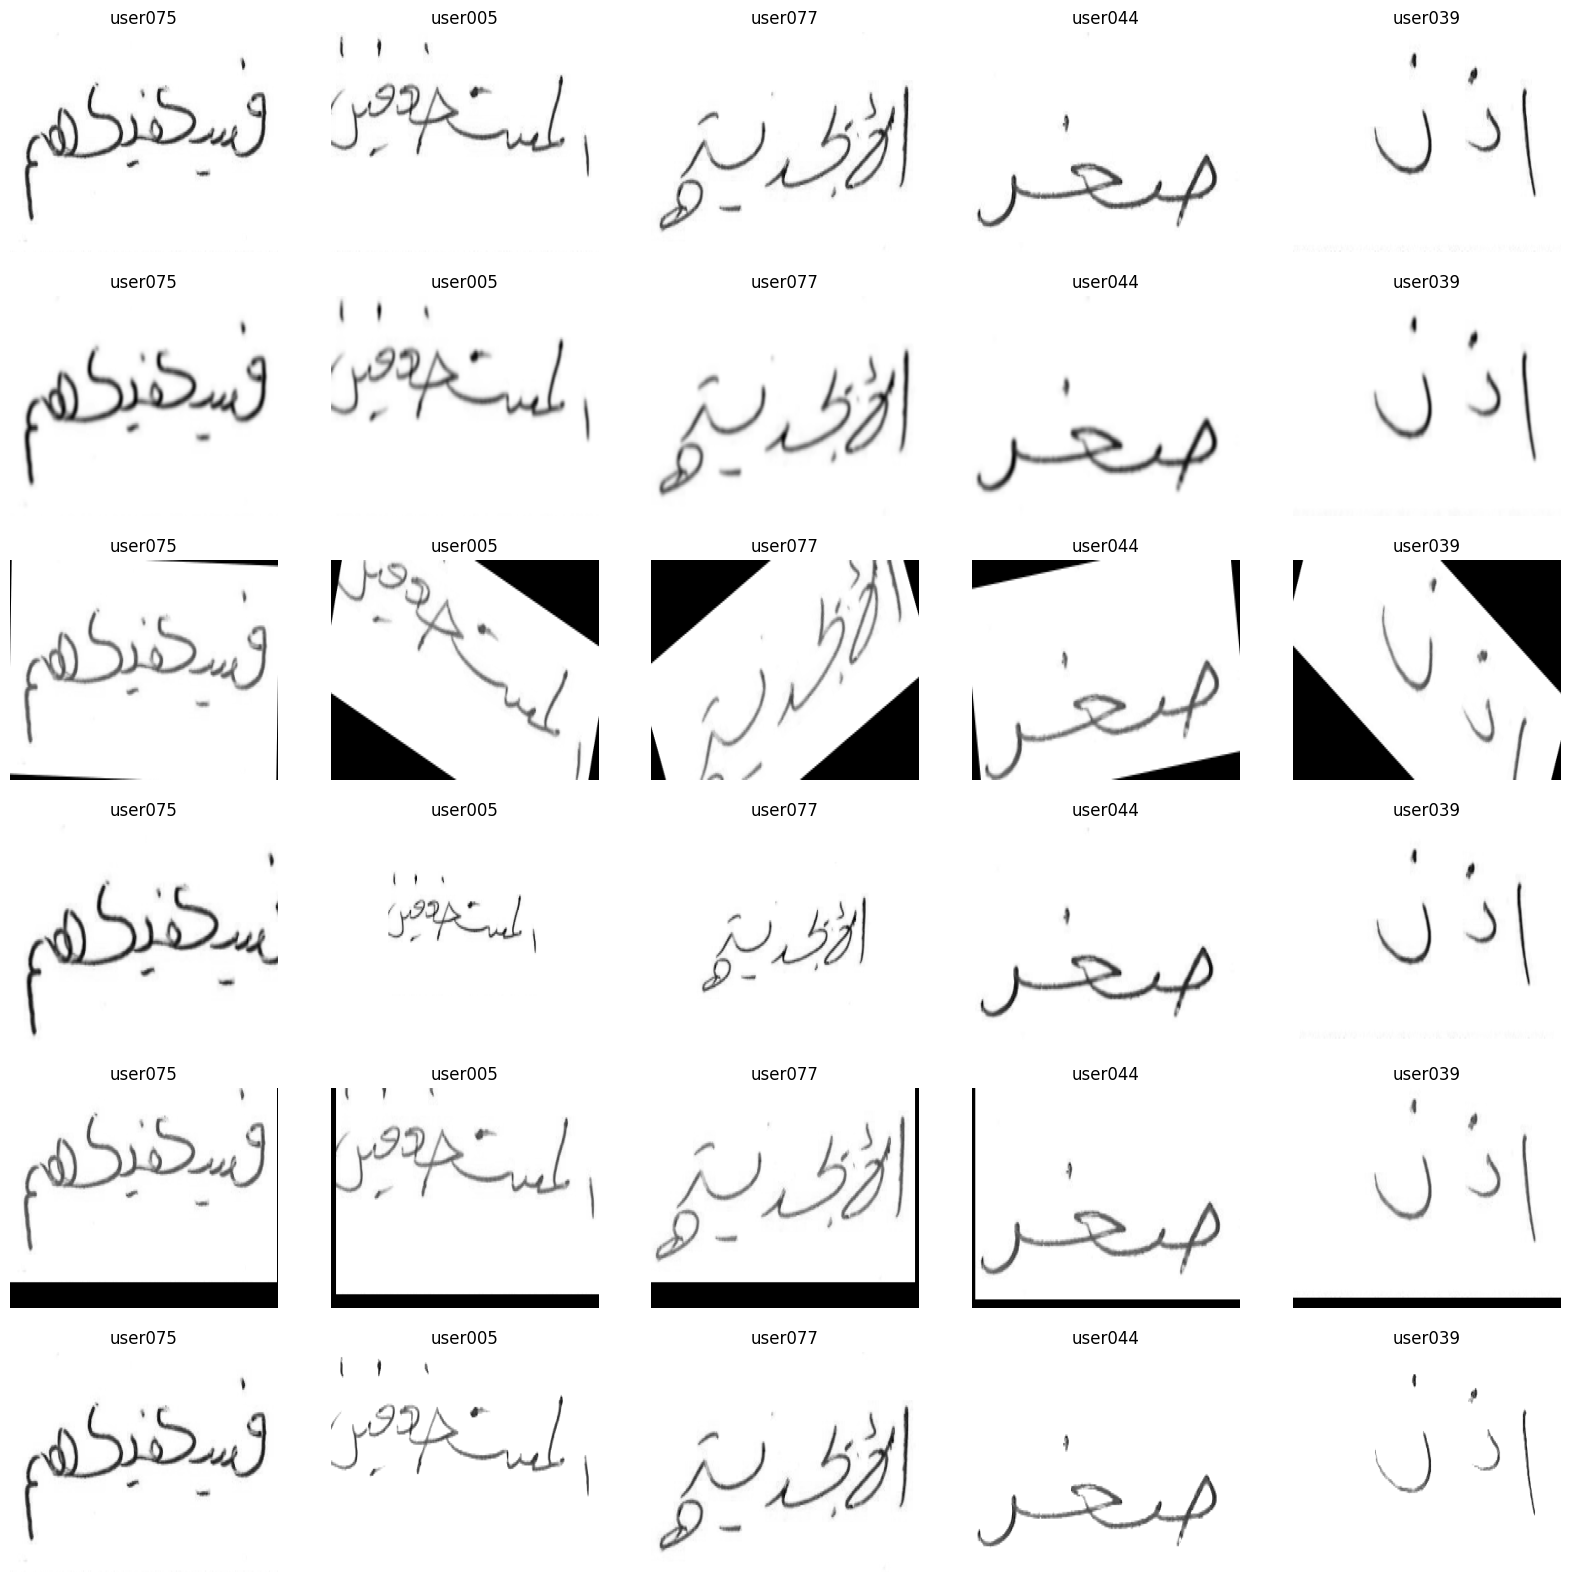

In [14]:

test_data_sets = {}

# Original
test_data_sets['original'] = X_test.copy()

# Add Gaussian noise
test_data_sets['gaussian_noise'] = X_test.copy()
test_data_sets['gaussian_noise']['img'] = test_data_sets['gaussian_noise']['img'].apply(add_gaussian_noise)

# Random rotation
test_data_sets['random_rotation'] = X_test.copy()
test_data_sets['random_rotation']['img'] = test_data_sets['random_rotation']['img'].apply(random_rotation)

# Scale image
test_data_sets['scale_image'] = X_test.copy()
test_data_sets['scale_image']['img'] = test_data_sets['scale_image']['img'].apply(scale_object_in_image)

# Translate image
test_data_sets['translate_image'] = X_test.copy()
test_data_sets['translate_image']['img'] = test_data_sets['translate_image']['img'].apply(translate_image)

# Change illumination

test_data_sets['change_illumination'] = X_test.copy()
test_data_sets['change_illumination']['img'] = test_data_sets['change_illumination']['img'].apply(change_illumination)

# Display the first 5 images of each
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 5, figsize=(20, 20))
for i, (data_set, data) in enumerate(test_data_sets.items()):
    for j in range(5):
        axes[i, j].imshow(data['img'].iloc[j], cmap='gray')
        axes[i, j].set_title(y_test.iloc[j])
        axes[i, j].axis('off')
        axes[i, j].set_aspect('auto')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_xticklabels([])
        axes[i, j].set_yticklabels([])
        axes[i, j].grid(False)
        if j == 0:
            axes[i, j].set_ylabel(data_set, fontsize=16)



In [ ]:

from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

algorithms = ['sift', 'orb']
clusters = list(range(100, 4500, 500))

accuracy_results = []


for algorithm in algorithms:
    for numOfClusters in clusters:
        print(f"Algorithm: {algorithm}, Number of Clusters: {numOfClusters}")
        # Extract features for training data
        train_images = X_train['img'].tolist()
        train_labels = y_train['label'].tolist()
        print("Extracting features for training data...")
        train_features, train_labels, kmeans = extract_features(
                                                images=train_images,
                                                labels=train_labels,
                                                algorithm=algorithm,
                                                numOfClusters=numOfClusters,
                                                )

        # Extract features for testing data using the trained kMeans
        val_images = X_val['img'].tolist()
        val_labels = y_val['label'].tolist()
        print("Extracting features for testing data...")
        val_features, val_labels = extract_features(
            images=val_images,
            labels=val_labels,
            algorithm=algorithm,
            Test=True,
            kMeans=kmeans
        )

        # Initialize the SVM classifier
        svm_clf = SVC(random_state=42, C=10, kernel='rbf', gamma='auto')

        # Train the SVM classifier
        print("Training the SVM classifier...")
        svm_clf.fit(train_features, train_labels)

        # Make predictions
        print("Making predictions...")
        predictions = svm_clf.predict(val_features)

        # Calculate accuracy
        accuracy = accuracy_score(val_labels, predictions)
        print(f"Accuracy on validation set: {accuracy:.2f}")

        accuracy_results.append({
            'algorithm': algorithm,
            'numOfClusters': numOfClusters,
            'accuracy': accuracy
        })
        print("======================================\n\n")

Algorithm: sift, Number of Clusters: 100
Extracting features for training data...
Number of processed images:  6515
Clustering descriptors...
Using GPU: True
Clustering complete. Number of clusters: 100
Forming feature vectors...
Extracting features for testing data...
Number of processed images:  1629
Training the SVM classifier...
Making predictions...
Accuracy: 0.11


Algorithm: sift, Number of Clusters: 600
Extracting features for training data...
Number of processed images:  6515
Clustering descriptors...
Using GPU: True
Clustering complete. Number of clusters: 600
Forming feature vectors...
Extracting features for testing data...
Number of processed images:  1629
Training the SVM classifier...
Making predictions...
Accuracy: 0.16


Algorithm: sift, Number of Clusters: 1100
Extracting features for training data...
Number of processed images:  6515
Clustering descriptors...
Using GPU: True
Clustering complete. Number of clusters: 1100
Forming feature vectors...
Extracting features 

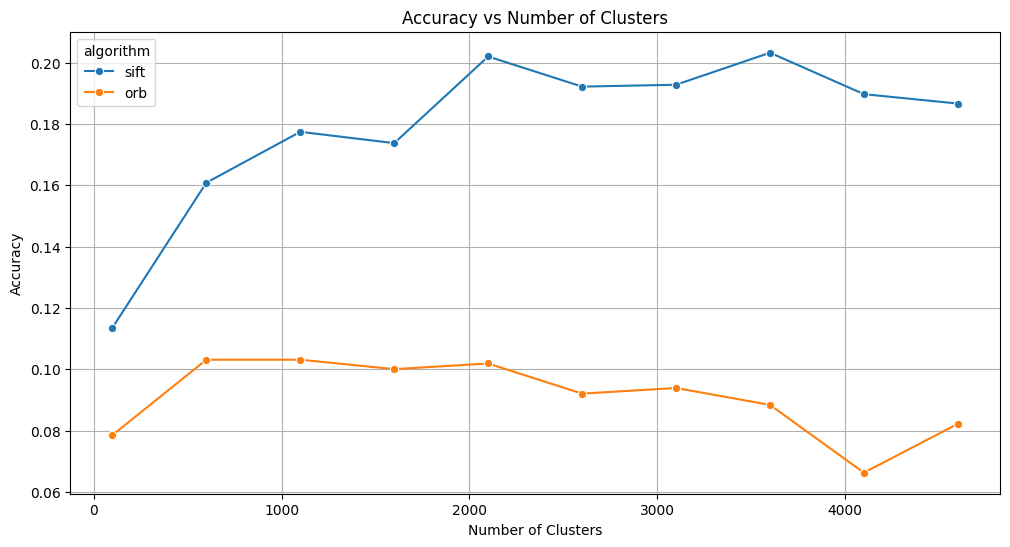

In [ ]:
#plot the results
import seaborn as sns
import matplotlib.pyplot as plt

results_df = pd.DataFrame(accuracy_results)

plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='numOfClusters', y='accuracy', hue='algorithm', marker='o')
plt.title('Accuracy vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [ ]:
algorithms = ['sift', 'orb']

numOfClusters = 1000
for test_set in test_data_sets.keys():
    print(f"Test Set: {test_set}")
    accuracy_results = []
    for algorithm in algorithms:
        print(f"Algorithm: {algorithm}, Number of Clusters: {numOfClusters}")
        # Extract features for training data
        train_images = X_train['img'].tolist()
        train_labels = y_train['label'].tolist()
        print("Extracting features for training data...")
        train_features, train_labels, kmeans = extract_features(
                                                images=train_images,
                                                labels=train_labels,
                                                algorithm=algorithm,
                                                numOfClusters=numOfClusters,
                                                )

        # Extract features for testing data using the trained kMeans
        test_images = test_data_sets[test_set]['img'].tolist()
        test_labels = y_test['labels'].tolist()
        print("Extracting features for testing data...")
        test_features, test_labels = extract_features(
            images=test_images,
            labels=test_labels,
            algorithm=algorithm,
            Test=True,
            kMeans=kmeans
        )

        # Initialize the SVM classifier
        svm_clf = SVC(random_state=42, C=10, kernel='rbf', gamma='auto')

        # Train the SVM classifier
        print("Training the SVM classifier...")
        svm_clf.fit(train_features, train_labels)

        # Make predictions
        print("Making predictions...")
        predictions = svm_clf.predict(test_features)

        # Calculate accuracy
        accuracy = accuracy_score(test_labels, predictions)
        print(f"Accuracy: {accuracy:.2f}")

        accuracy_results.append({
            'algorithm': algorithm,
            'robusness': test_set,
            'accuracy': accuracy
        })
            
        print("======================================\n\n")

   

In [ ]:
results_df = pd.DataFrame(accuracy_results)
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='algorithm', y='accuracy', hue='robusness')
plt.title('Accuracy vs Algorithm')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')

    

In [ ]:
images = df['img'].tolist()
labels = df['label'].tolist()

time_extraction, clustering_time, forming_time = extract_features(
                                                                  images,
                                                                  labels,
                                                                  algorithm='sift',
                                                                  numOfClusters=1000,
                                                                  Compare=True
                                                              )

print(f"Average Time taken for feature extraction using SIFT: {sum(time_extraction)/len(time_extraction):.2f} seconds")
print(f"Time taken for clustering: {clustering_time:.2f} seconds")
print(f"Time taken for forming the feature vectors: {forming_time:.2f} seconds")

print("======================================\n\n")


time_extraction, clustering_time, forming_time = extract_features(
                                                                  images,
                                                                  labels,
                                                                  algorithm='orb',
                                                                  numOfClusters=1000,
                                                                  Compare=True
                                                              )

print(f"Average Time taken for feature extraction using ORB: {sum(time_extraction)/len(time_extraction):.2f} seconds")
print(f"Time taken for clustering: {clustering_time:.2f} seconds")
print(f"Time taken for forming the feature vectors: {forming_time:.2f} seconds")

print("======================================\n\n")



Number of processed images:  8144
Average number of keypoints per image:  90.99803536345776
Average time for feature extraction:  0.010298909923182489
Clustering descriptors...
Using GPU: True
Clustering complete. Number of clusters: 1000
Clustering time: 2.06 seconds
Forming feature vectors...
Forming time: 3.75 seconds
Number of processed images:  8144
Average number of keypoints per image:  175.93848231827113
Average time for feature extraction:  0.0013040416894118303
Clustering descriptors...
Using GPU: True
Clustering complete. Number of clusters: 1000
Clustering time: 1.02 seconds
Forming feature vectors...
Forming time: 4.25 seconds


In [ ]:
imgGrey = cv.imread('test_img.jpg', cv.IMREAD_GRAYSCALE)



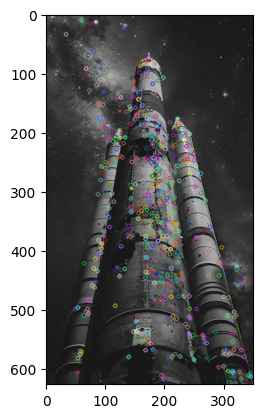

In [ ]:
keypoints, des=sift(imgGrey, test=True)

In [ ]:
len(keypoints)

648

In [ ]:
des.shape

(648, 128)

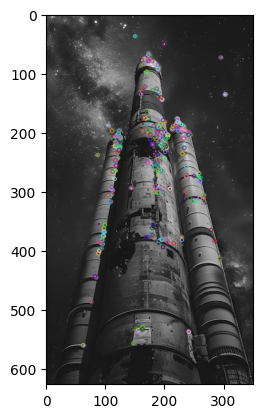

In [ ]:
keypoints, des=orb(imgGrey, test=True)

In [ ]:
len(keypoints)

500

In [ ]:
des.shape

(500, 32)